# Models: Generalized Matrix Factorization (GMF)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
BASE_PATH    = '../..'
LIB_PATH     = f'{BASE_PATH}/lib'
DATASET_PATH = f'{BASE_PATH}/datasets'
WEIGHTS_PATH = f'{BASE_PATH}/weights'
METRICS_PATH = f'{BASE_PATH}/metrics/gmf'

In [19]:
import sys
# sys.path.append(f'/home/adrian/development/personal/pytorch_common')
sys.path.append(LIB_PATH)

import numpy as np
import pandas as pd
from bunch import Bunch

import torch
from torch.utils.data import DataLoader, Subset
from torch.optim import SparseAdam, Adam
from sklearn.metrics import roc_auc_score

import pytorch_common.util as pu
from pytorch_common.modules.fn import Fn
from pytorch_common.callbacks import EarlyStop, \
                                     ReduceLROnPlateau, \
                                     Validation, \
                                     SaveBestModel
from pytorch_common.callbacks.output import Logger, \
                                            MetricsPlotter

import model as ml
import data.dataset as ds

import metric as mt
import metric.discretizer as dr

import data.plot as pl
import data as dt

import logging
import random

import util as ut

## Setup

In [4]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

In [5]:
import pytorch_common
pytorch_common.__version__

'0.1.0'

In [6]:
torch.__version__

'1.11.0'

In [7]:
pu.set_device_name('gpu')
cpu = torch.device("cpu")

pu.get_device(), torch.cuda.is_available()

(device(type='cuda', index=0), True)

In [8]:
ut.set_seed(42)

In [9]:
TRAIN = False

## Carga de dataset

In [10]:
def to_tensor(obs, device, columns): 
    data = obs[columns]
    if type(data) == pd.DataFrame:
        data = data.values
    return torch.tensor(data).to(device)

features_fn = lambda obs, device: to_tensor(obs, device, ['user_seq', 'movie_seq'])
target_fn   = lambda obs, device: to_tensor(obs, device, ['user_movie_rating'])

dataset = ds.MovieLensTMDBDatasetFactory.from_path(
    path             = DATASET_PATH,
    transform        = features_fn,
    target_transform = target_fn,
    device           = cpu,
    filter_fn        = lambda df: df[(df['user_movie_rating_year'] >= 2005) & (df['user_movie_rating_year'] <= 2019)]
)
dataset.info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 153892 entries, 0 to 153891
Data columns (total 16 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   user_id                      153892 non-null  int64         
 1   user_seq                     153892 non-null  int64         
 2   user_movie_tags              153892 non-null  object        
 3   user_movie_rating            153892 non-null  int64         
 4   user_movie_rating_timestamp  153892 non-null  datetime64[ns]
 5   user_movie_rating_year       153892 non-null  int64         
 6   movie_id                     153892 non-null  int64         
 7   movie_seq                    153892 non-null  int64         
 8   movie_title                  153892 non-null  string        
 9   movie_genres                 153892 non-null  object        
 10  movie_for_adults             153892 non-null  bool          
 11  movie_original_language   

In [11]:
train_set, eval_set = dataset.split_train_eval(split_year=2018)

2023-04-10 20:02:58,601 - INFO - Train: 82.85 % - Test: 8.97 %


## Definicion del modelo

In [12]:
params = Bunch({
    'lr'             : 0.001,
    'lr_factor'      : 0.1,
    'lr_patience'    : 3,
    'epochs'         : 50,
    'embedding_size' : 50,
    'n_workers'      : 24,
    'batch_size'     : 64,
    'n_users'        : len(dataset.features_uniques[0]),
    'n_items'        : len(dataset.features_uniques[1])
})

In [13]:
train_dl = DataLoader(train_set, params.batch_size, num_workers=params.n_workers, pin_memory=True)
test_dl  = DataLoader(eval_set,  params.batch_size, num_workers=params.n_workers, pin_memory=True)

In [14]:
model = ml.GMF(
    n_users        = params.n_users,
    n_items        = params.n_items,
    embedding_size = params.embedding_size
).to(pu.get_device())
model

GMF(
  (embedding): MultiFeatureEmbedding(
    (embedding): Embedding(19285, 50)
  )
  (dot): BatchDot()
)

## Entrenamiento del modelo

In [15]:
if TRAIN:
    result = model.fit(
        train_dl,
        epochs      = params.epochs,
        loss_fn     = ml.MSELossFn(),
        optimizer   = Adam(
            params       = model.parameters(),
            lr           = params.lr
        ),
        callbacks   = [
            Validation(
                test_dl,
                metrics       = { 'val_loss': ml.MSELossFn(float_result=True)},
                each_n_epochs = 1
            ),
            ReduceLROnPlateau(metric='val_loss', mode='min', factor=params.lr_factor, patience=params.lr_patience),
            MetricsPlotter(metrics=['train_loss', 'val_loss'], plot_each_n_epochs=2),
            Logger(['time', 'epoch', 'train_loss', 'val_loss', 'patience', 'lr']),
            SaveBestModel(metric='val_loss', path=WEIGHTS_PATH, experiment_name='gfm')
        ]
    )

In [16]:
model.load(f'{WEIGHTS_PATH}/2023-04-06_15-24-34--gfm--epoch_23--val_loss_0.9011892676353455')

n_classes = len(dataset.target_uniques)

validator = ml.Validator(
    n_samples  = 500,
    batch_size = 10000,
    metrics    = [
        mt.RMSE(),

        mt.MeanNdcgAtk            (k=5),
        mt.MeanAveragePrecisionAtk(k=5, discretizer=dr.between(4, 5)),
        mt.MeanUserFBetaScoreAtk  (k=5, n_classes=n_classes, discretizer=dr.between(4, 5)),
        mt.MeanUserPrecisionAtk   (k=5, n_classes=n_classes, discretizer=dr.between(4, 5)),
        mt.MeanUserRecallAtk      (k=5, n_classes=n_classes, discretizer=dr.between(4, 5)),

        mt.MeanAveragePrecisionAtk(k=5, discretizer=dr.between(3, 5)),
        mt.MeanUserFBetaScoreAtk  (k=5, n_classes=n_classes, discretizer=dr.between(3, 5)),
        mt.MeanUserPrecisionAtk   (k=5, n_classes=n_classes, discretizer=dr.between(3, 5)),
        mt.MeanUserRecallAtk      (k=5, n_classes=n_classes, discretizer=dr.between(3, 5))
    ],
    predictors = [ml.ModulePredictor(model)]
)

summary = validator.validate(eval_set)
summary.save(METRICS_PATH)

Processing:   0%|          | 0/500 [00:00<?, ?it/s]

In [17]:
summary = ml.ValidatorSummary.load(METRICS_PATH)
summary.show()

Ordered by mAP@5(4,5):


,sample,RMSE,mNDCG@5,"mAP@5(4,5)","MeanUserF1.0Score@5(4,5)","Precision@5(4,5)","Recall@5(4,5)","mAP@5(3,5)","MeanUserF1.0Score@5(3,5)","Precision@5(3,5)","Recall@5(3,5)"
predictor,,,,,,,,,,,
GMF,249.5,0.949594,0.961157,0.435179,0.684066,0.684089,0.684024,0.471224,0.811455,0.811713,0.811292


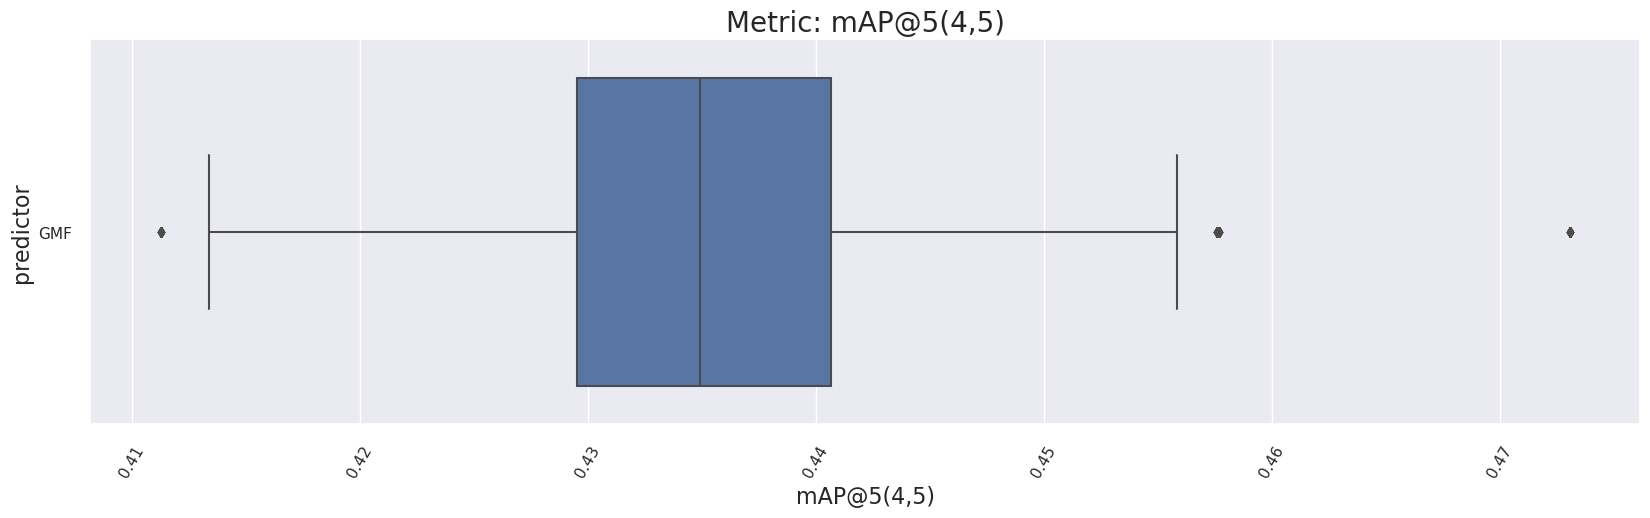

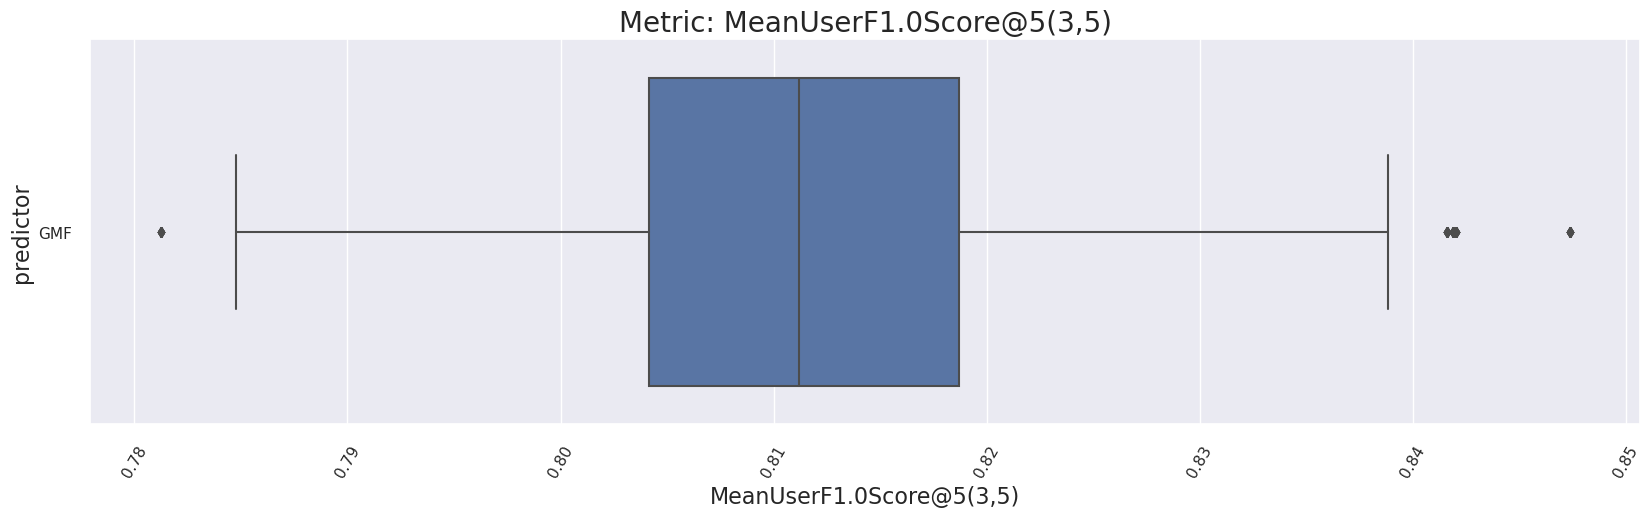

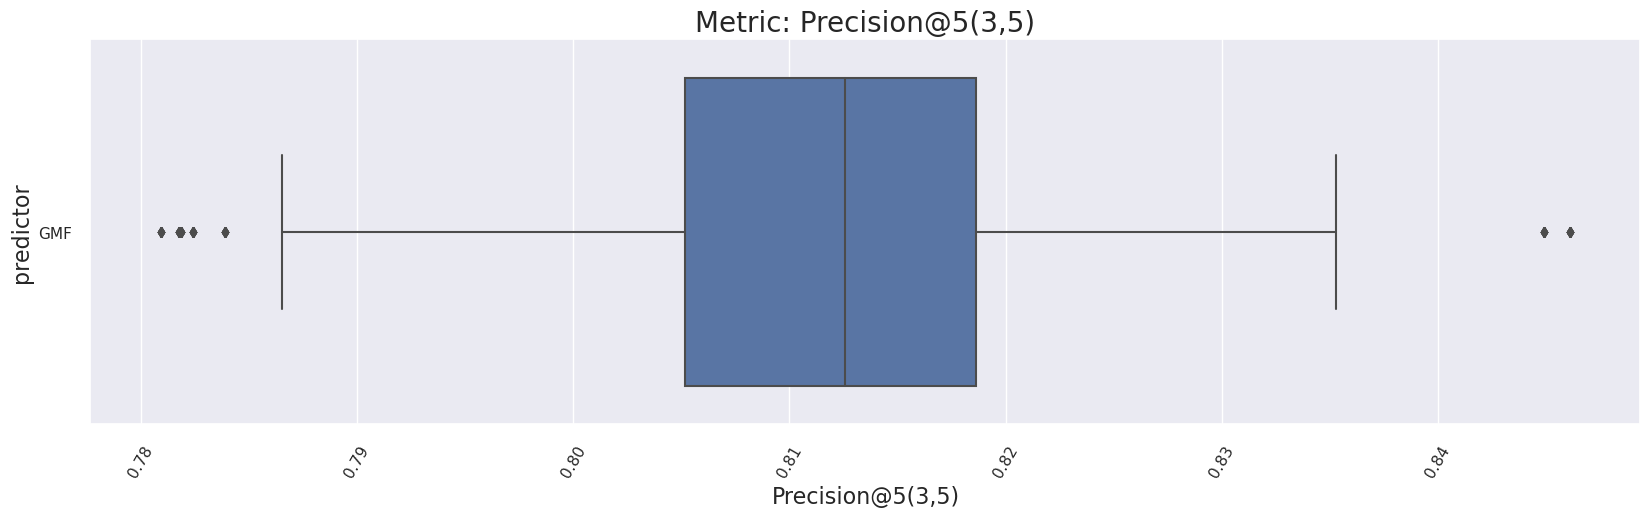

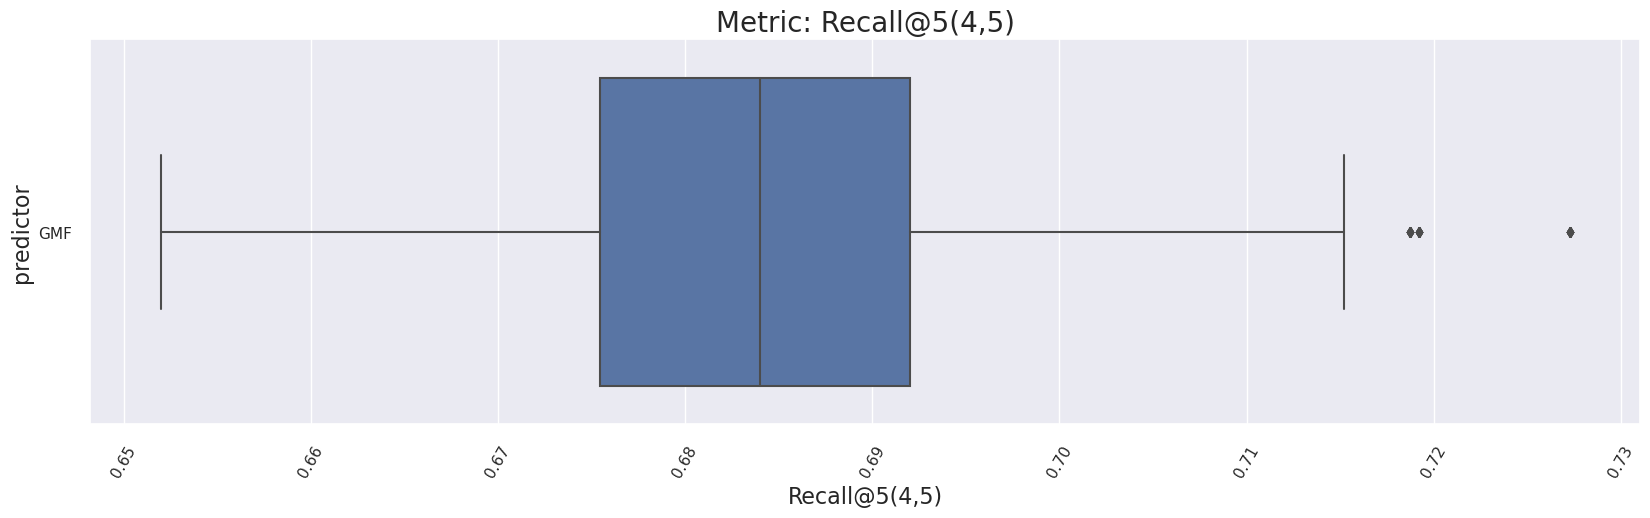

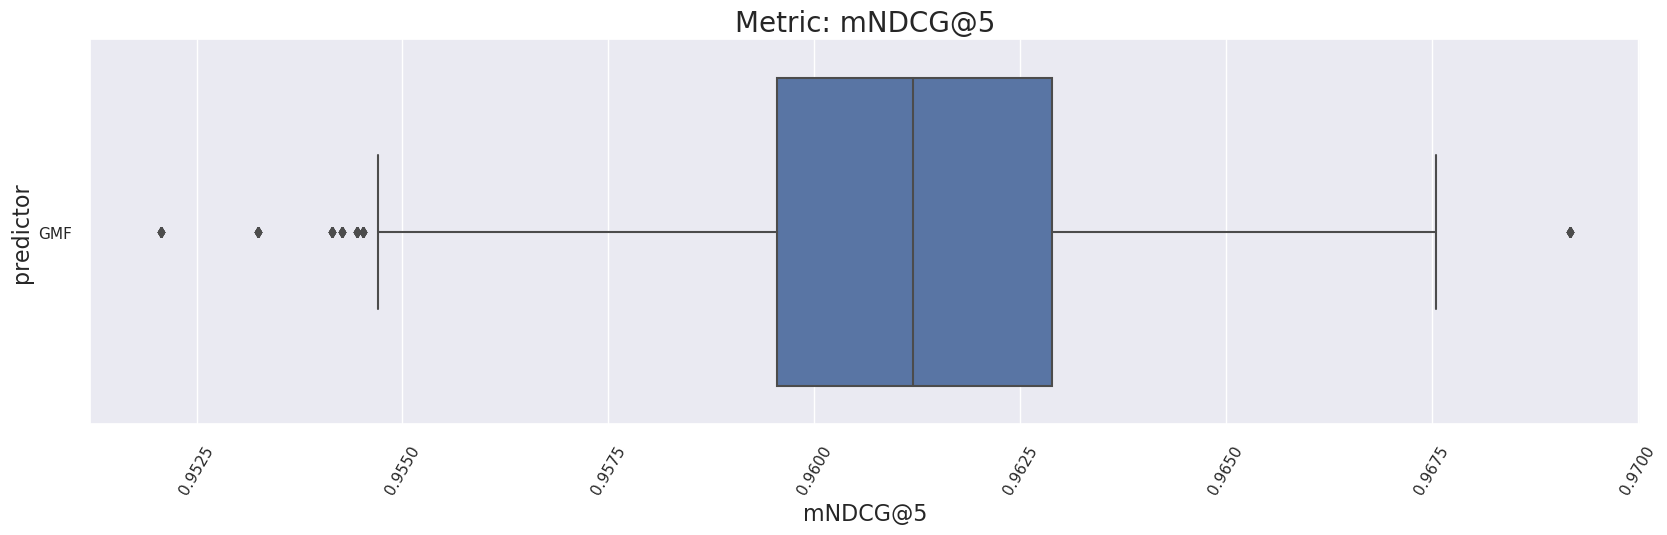

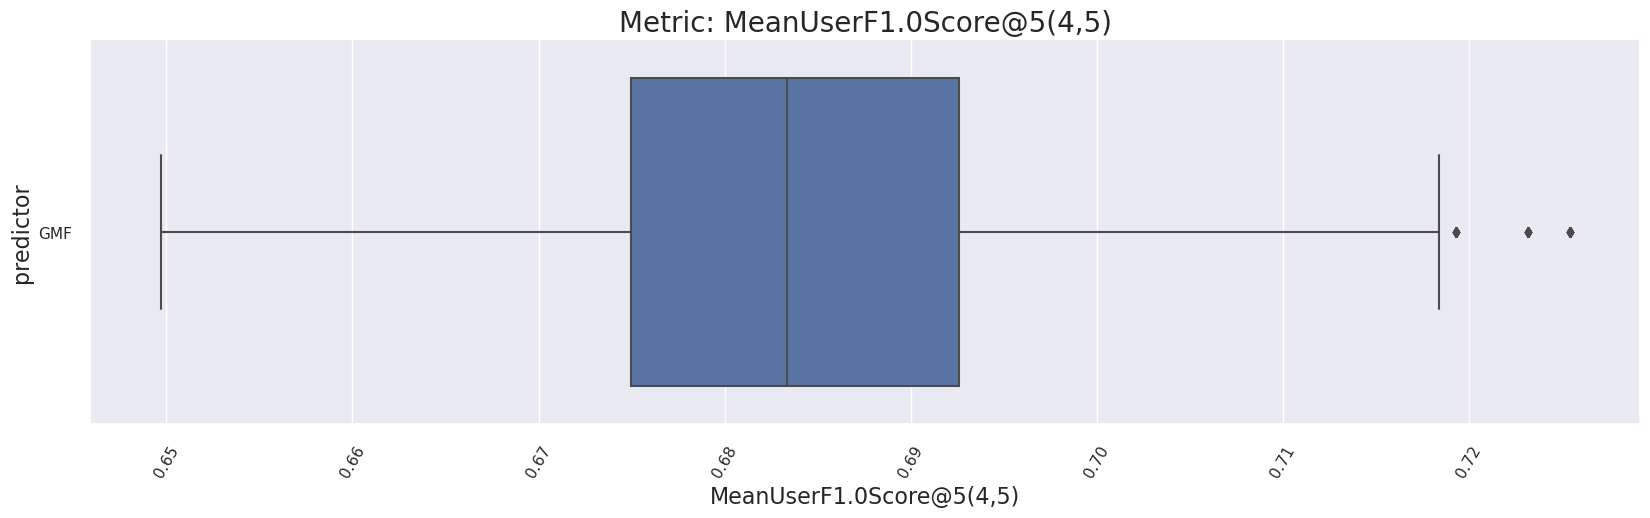

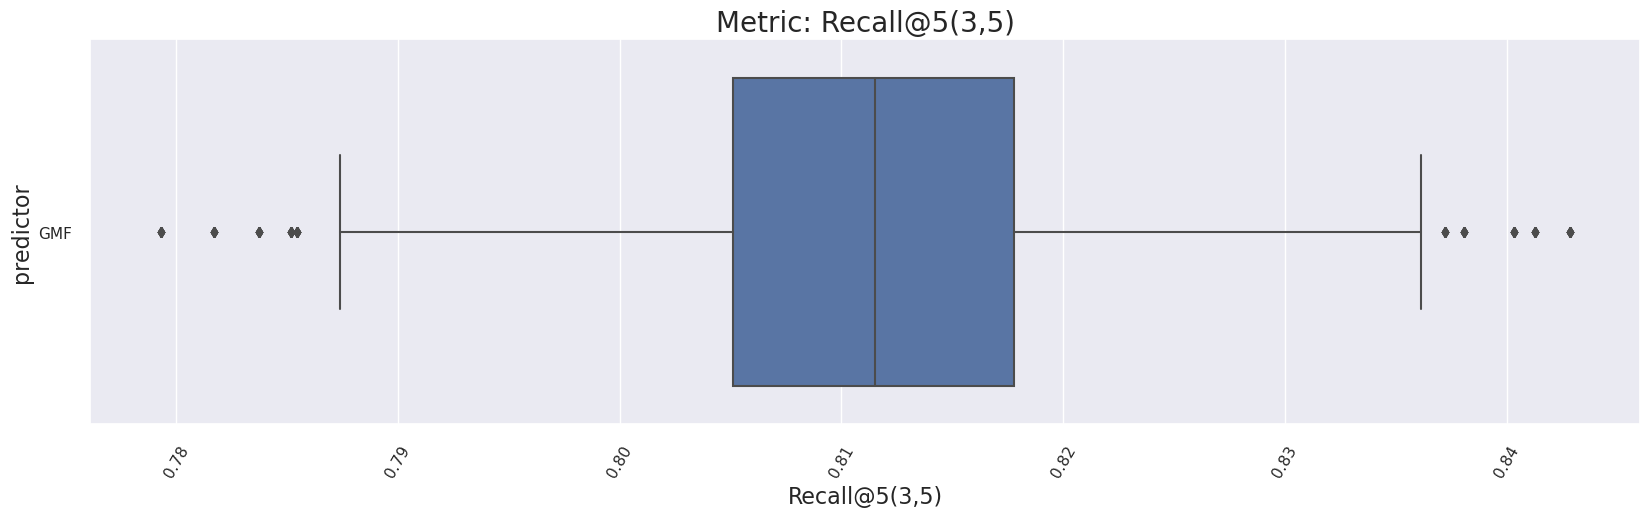

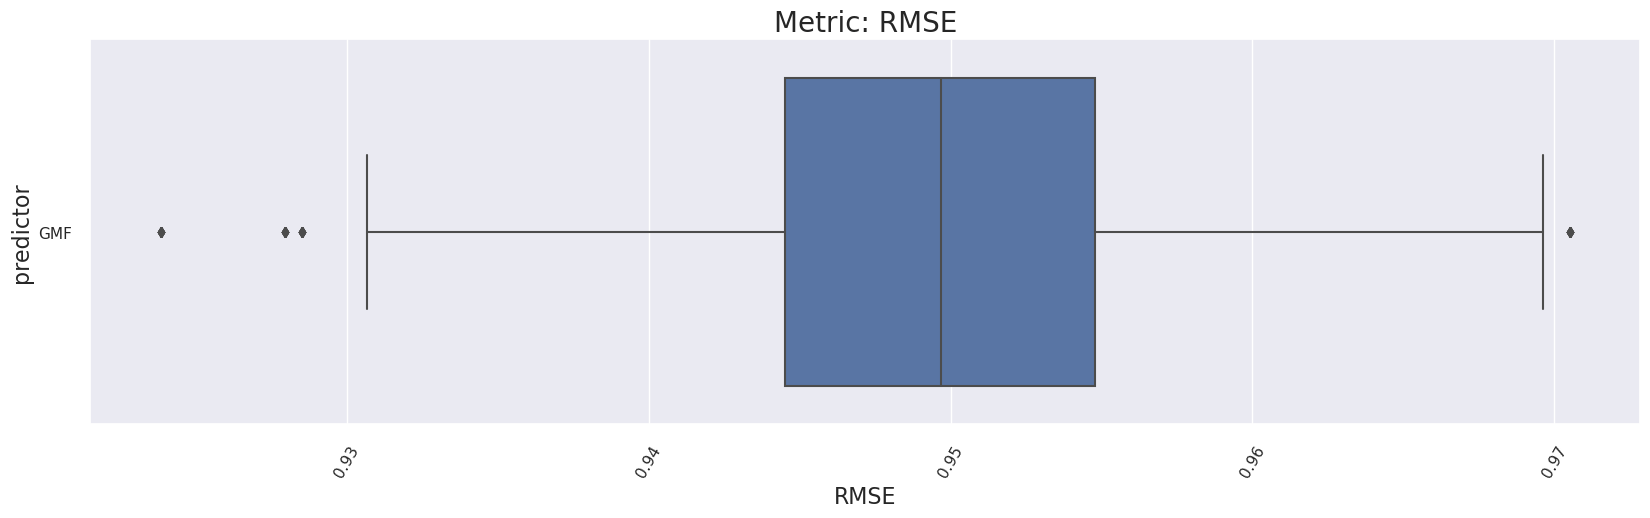

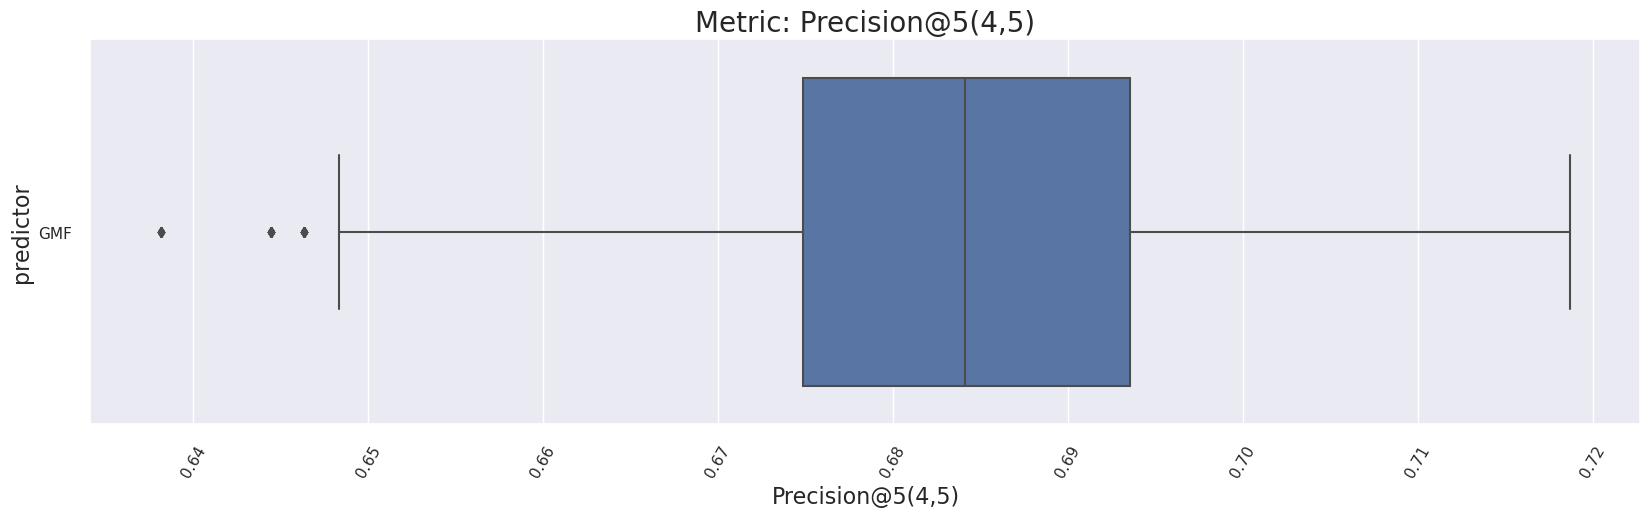

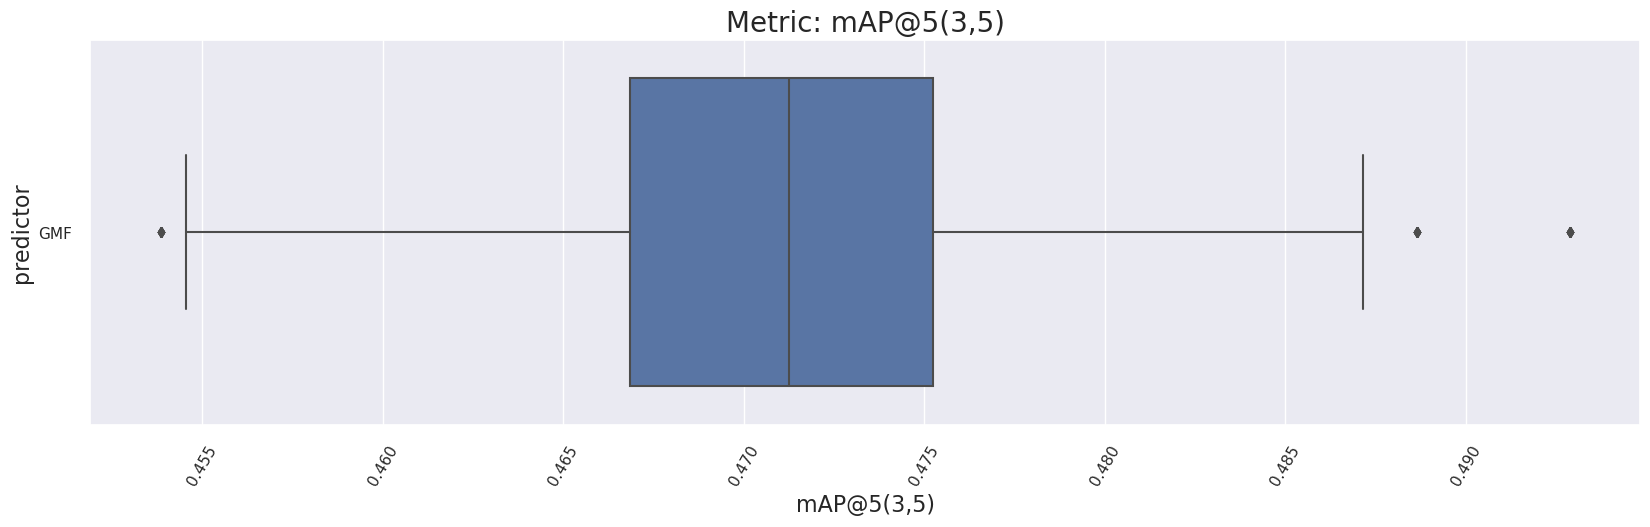

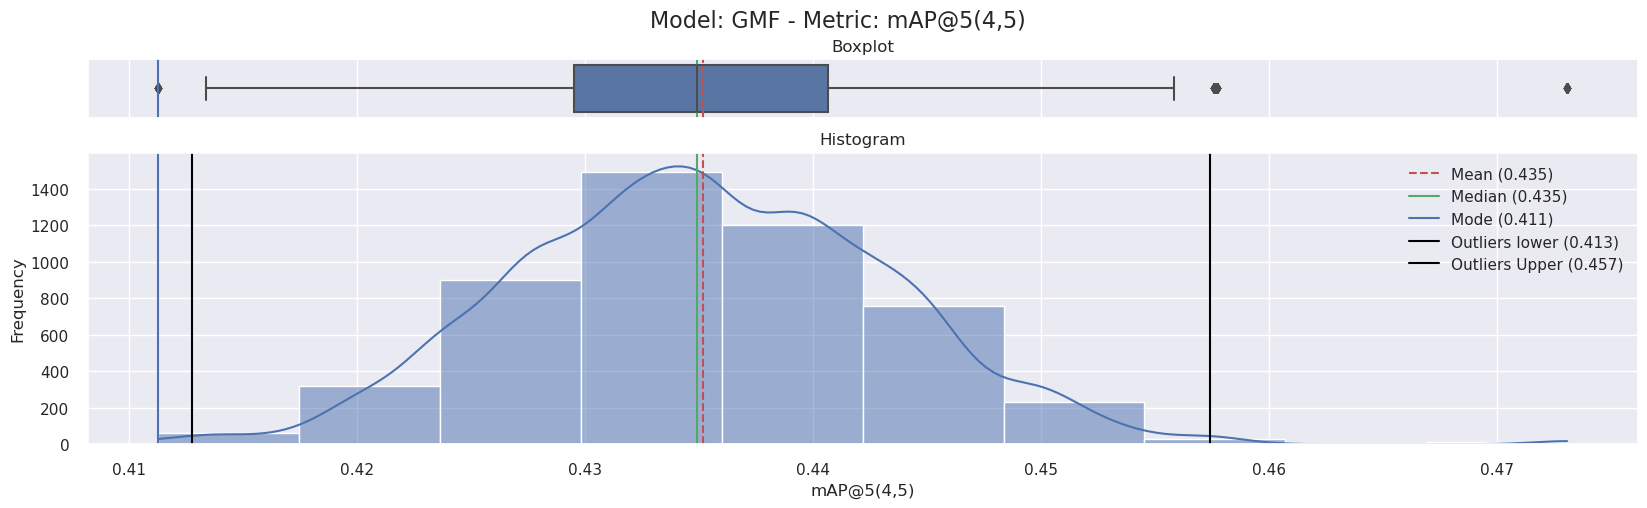

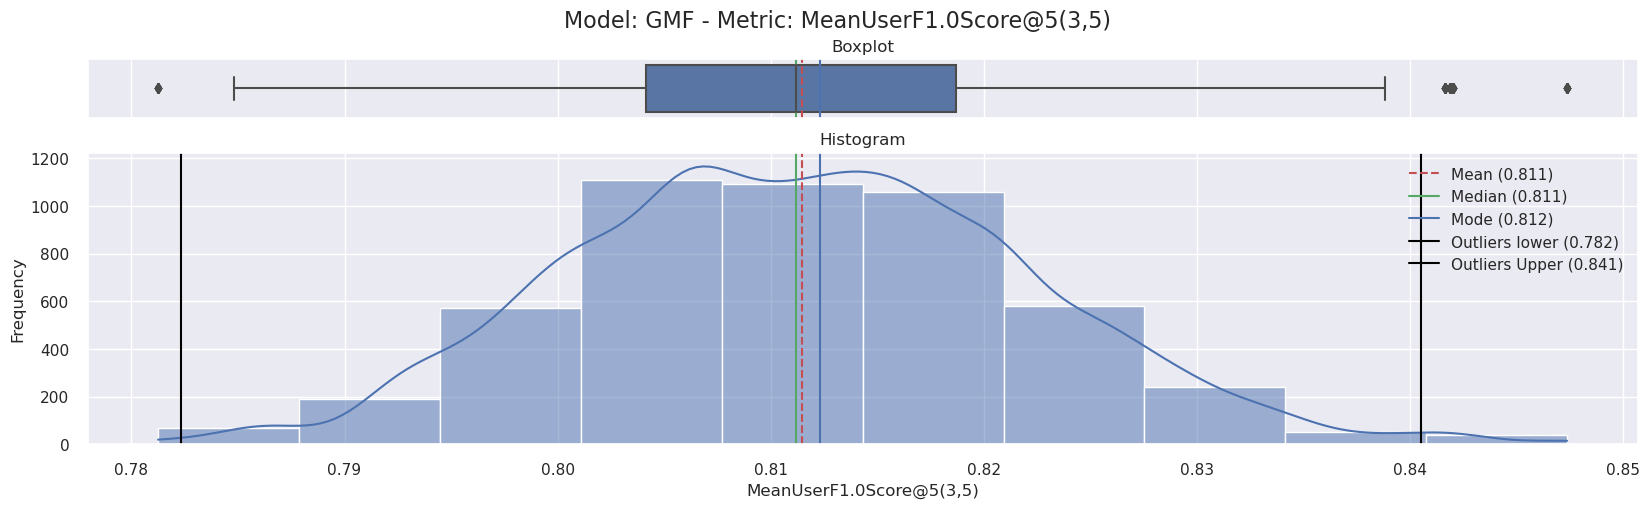

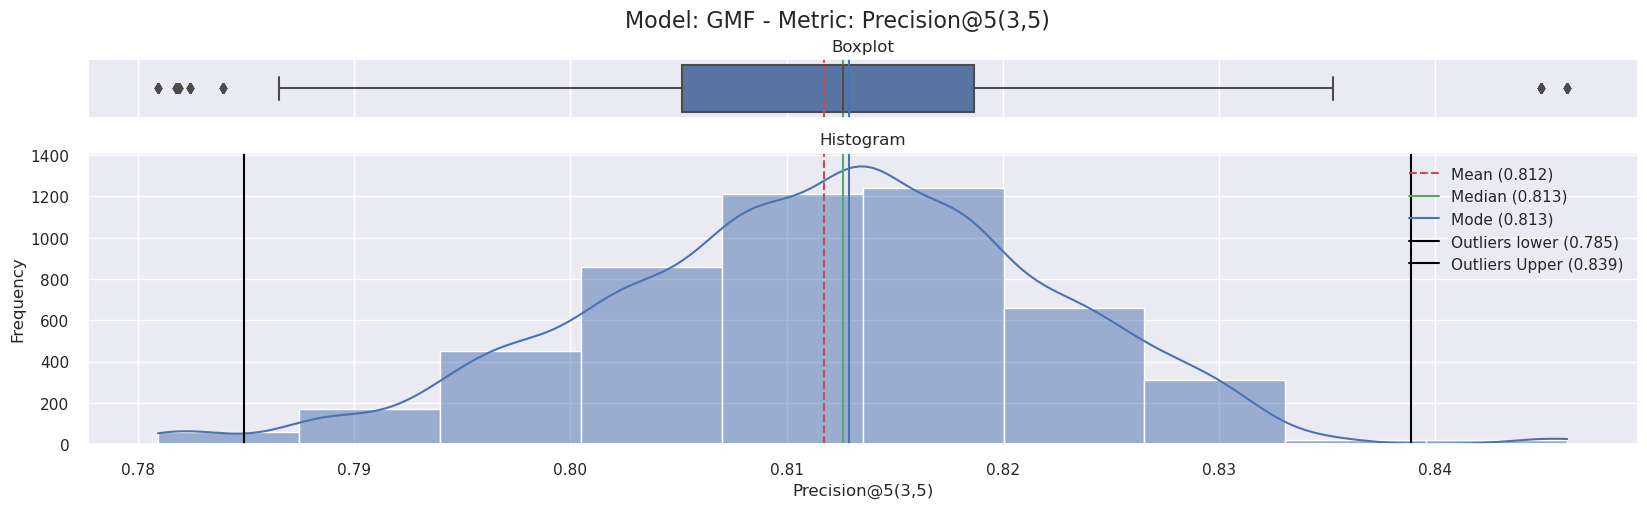

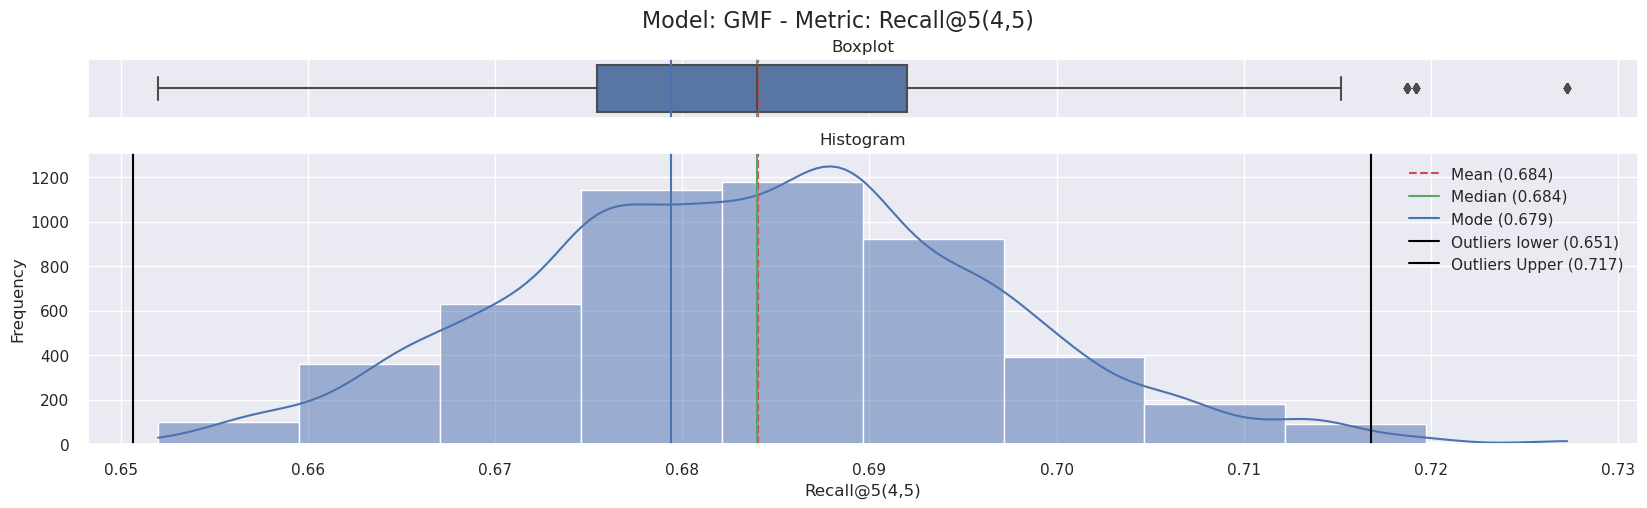

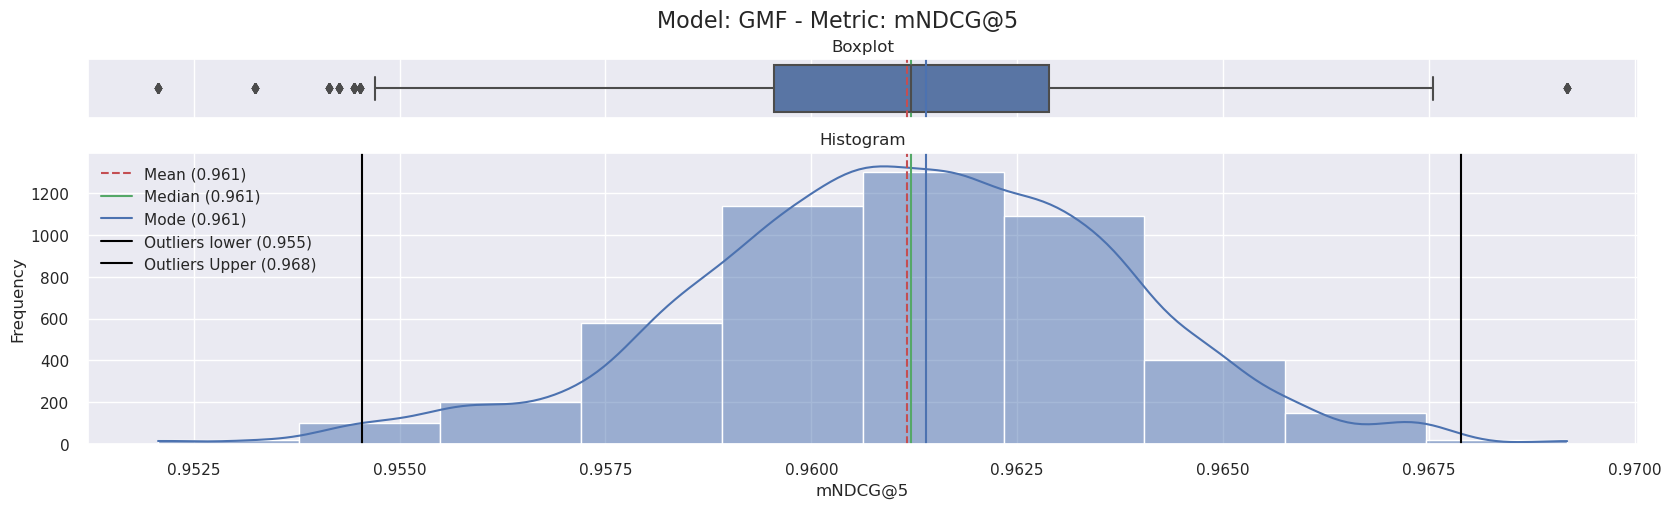

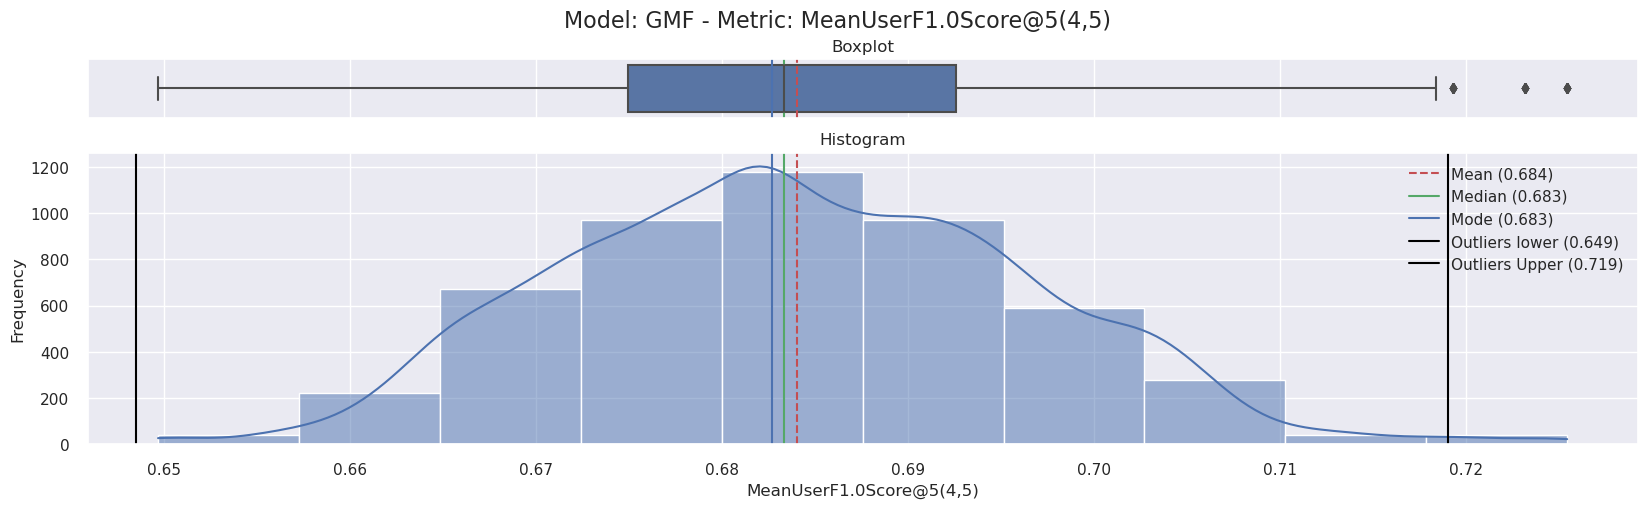

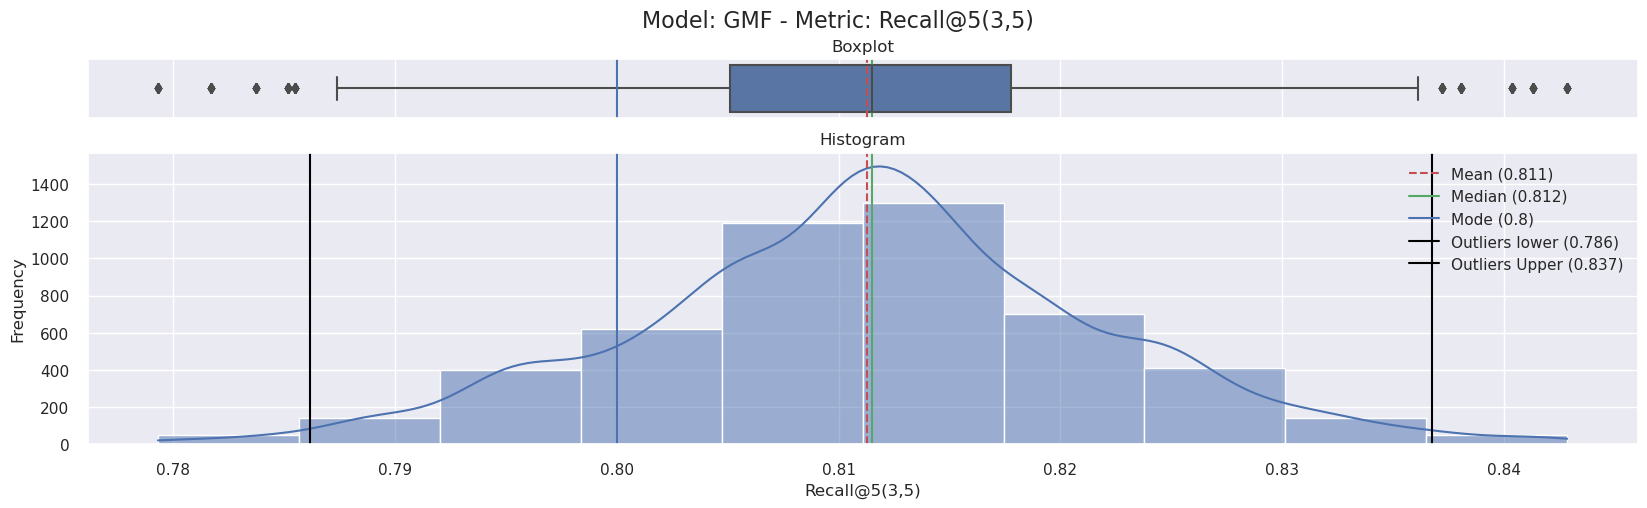

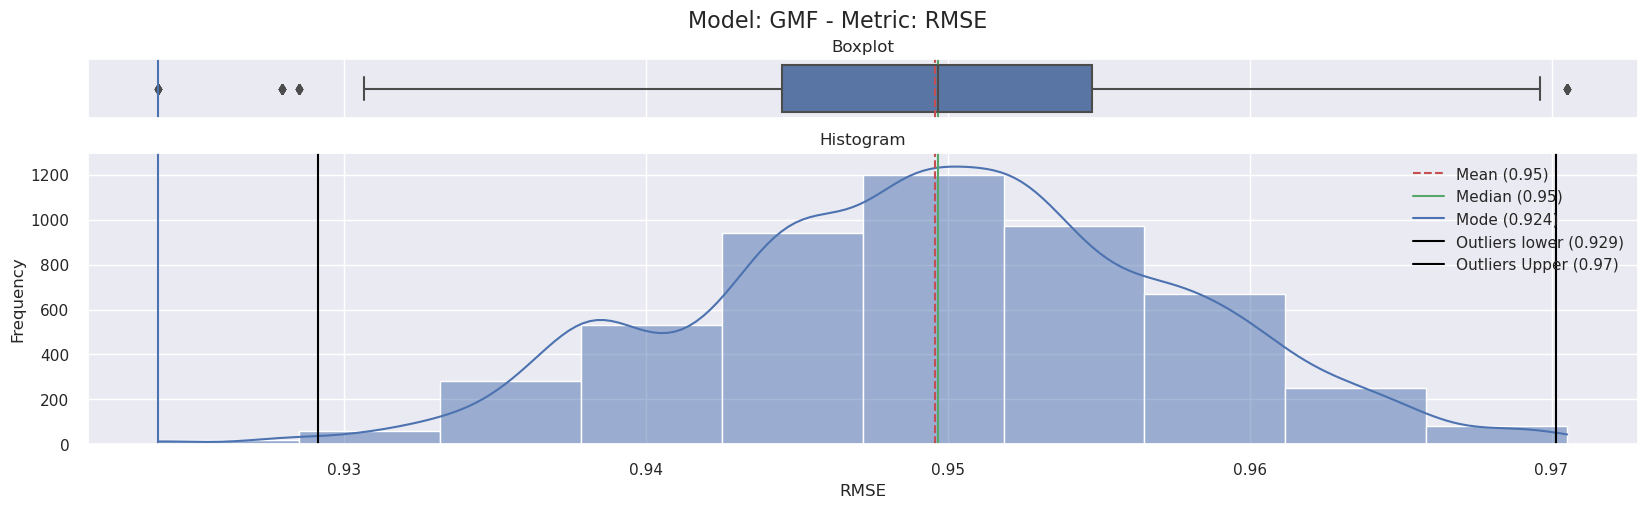

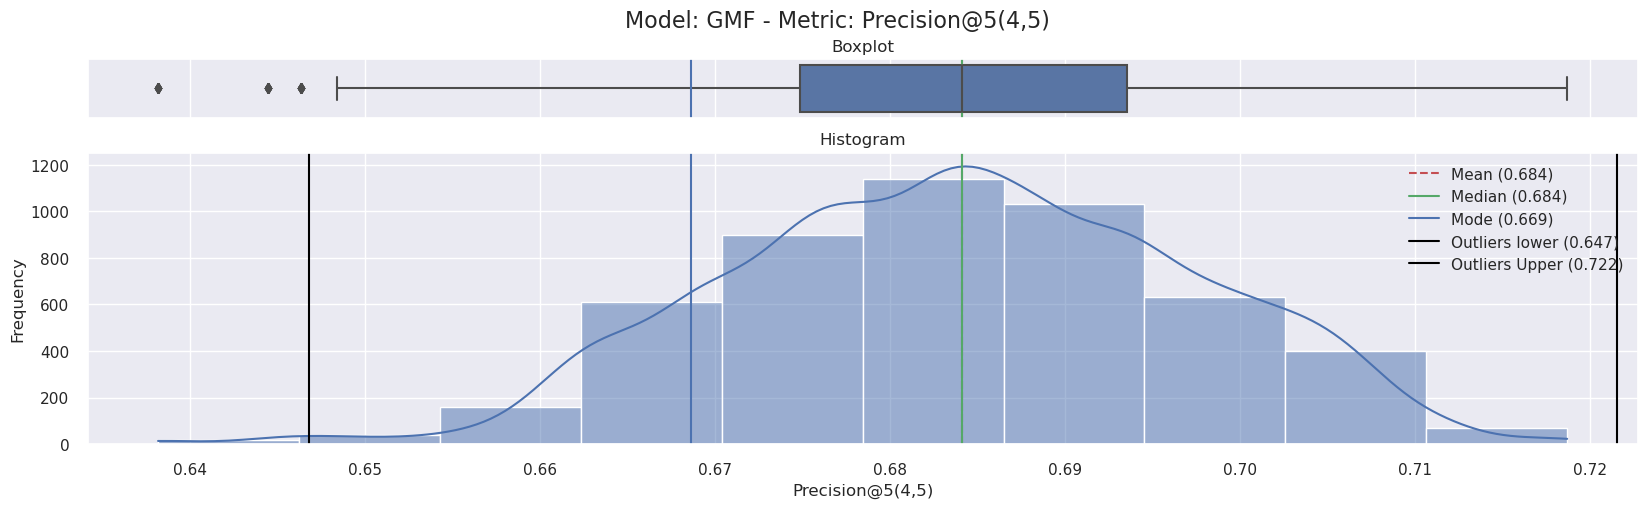

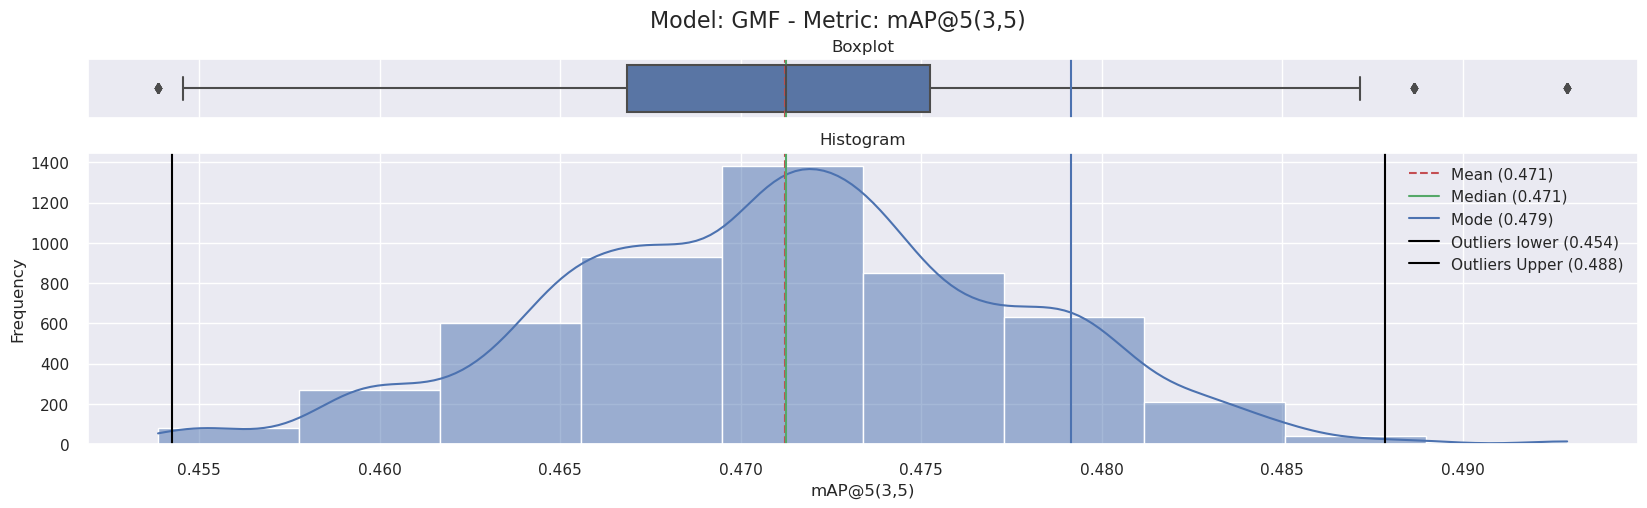

In [18]:
summary.plot()